### Taxi
![](https://miro.medium.com/max/400/1*SzwlbwcQME6NFoVFbDCrhA.png)


---------------------------------


 


In [1]:
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value


    def get_value(self, state):
        
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max([self.get_qvalue(state,action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        qvalue_target = reward+gamma*self.get_value(next_state)
        qvalue = learning_rate*qvalue_target+(1-learning_rate)*self.get_qvalue(state,action)
        
        self.set_qvalue(state, action, qvalue)

    
    def get_best_action(self, state):
       
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]
        return best_action

    def get_action(self, state):
       
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon
        exploration = random.random()
        if exploration<epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)
        
        return chosen_action

In [0]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [0]:
import random
from collections import deque

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = deque(maxlen=size)
        self._maxsize = size


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):

        data = (obs_t, action, reward, obs_tp1, done)

        self._storage.append(data)

    def sample(self, batch_size):
    
        idxes = [random.choice(range(self.__len__())) for _ in range(batch_size)]# randomly generate batch_size integers to be used as indexes of samples

        # collect <s,a,r,s',done> for each index
        obs_batch = []
        act_batch = []
        rew_batch = []
        next_obs_batch = []
        done_mask = []
        for idx in idxes:
            obs_batch.append(self._storage[idx][0])
            act_batch.append(self._storage[idx][1])
            rew_batch.append(self._storage[idx][2])
            next_obs_batch.append(self._storage[idx][3])
            done_mask.append(self._storage[idx][4])
            
        
        return np.array(obs_batch), np.array(act_batch), np.array(rew_batch), np.array(next_obs_batch), np.array(done_mask)

Now let's use this buffer to improve training:

In [0]:
import gym
env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [0]:
def play_and_train_with_replay(env, agent, replay=None, 
                               t_max=10**4, replay_batch_size=32):
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        agent.update(s,a,r,next_s,)        

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            replay.add(s,a,r,next_s,done)
            
            # sample replay_batch_size random transitions from replay, 
            # then update agent on each of them in a loop
            sample_s, sample_a, sample_s, sample_r, sample_s_next = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(sample_s[i], sample_a[i], sample_r[i],sample_s_next[i])
                    
        s = next_s
        total_reward +=r
        if done:break
    
    return total_reward

In [0]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 8.8
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 7.9


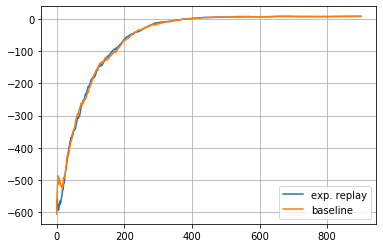

In [0]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None))
    
    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon, 'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon, 'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()
        